In [44]:
!pip install scikit-posthocs
!pip install shap
!pip install xgboost

In [45]:
import pandas as pd
import numpy as np
from collections import Counter


from scipy.stats import friedmanchisquare, rankdata, norm
from scipy.special import gammaln
import scikit_posthocs as sp
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import LeaveOneGroupOut

import time

from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
%matplotlib inline
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

import shap
# shap.initjs()

### Reading test results for each algorithm

In [46]:
df_mgbdt = pd.read_csv('/path/to/mgbdt_results')

In [47]:
df_catboost = pd.read_csv('/path/to/catboost_results')

In [48]:
df_node = pd.read_csv('/path/to/node_results.csv')

In [49]:
df_thunder = pd.read_csv('/path/to/thundergbm_results')

### We will compare the ROC-AUC results of each algorithm

In [50]:
mgbdt_auc = df_mgbdt.groupby('Dataset Name').mean()['AUC'].values

In [51]:
cat_auc = df_catboost.groupby('Dataset Name').mean()['AUC'].values

In [52]:
node_auc = df_node.groupby('Dataset Name').mean()['AUC'].values

In [53]:
thunder_auc = df_thunder.groupby('Dataset Name').mean()['AUC'].values

In [54]:
datasets_name = df_node['Dataset Name'].drop_duplicates().values

In [13]:
mgbdt_time = df_mgbdt.groupby('Dataset Name').mean()['Inference Time'].values

In [14]:
cat_time = df_catboost.groupby('Dataset Name').mean()['Inference Time'].values

In [15]:
node_time = df_node.groupby('Dataset Name').mean()['Inference Time'].values

In [16]:
thunder_time = df_thunder.groupby('Dataset Name').mean()['Inference Time'].values

# Friedman test

In [66]:
stat, p = friedmanchisquare(mgbdt_auc, thunder_auc, node_auc, cat_auc)


In [69]:
print('p=%.5f' % (p))
if p > 0.05:
	print('Do not reject the null hypothesis')
else:
	print('Reject null hypothesis')

p=0.00000
Reject null hypothesis


In [70]:
data = np.array([mgbdt_auc, thunder_auc, node_auc, cat_auc])

In [71]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [73]:
df_nemenyi = sp.posthoc_nemenyi_friedman(data.T,)
df_nemenyi.columns = ['mgbdt', 'thundergbm', 'node', 'catboost']
df_nemenyi.index = ['mgbdt', 'thundergbm', 'node', 'catboost']

In [75]:
df_nemenyi

,mgbdt,thundergbm,node,catboost
mgbdt,1.0000,0.0303,0.0010,0.0010
thundergbm,0.0303,1.0000,0.0010,0.0010
node,0.0010,0.0010,1.0000,0.0010
catboost,0.0010,0.0010,0.0010,1.0000


             mgbdt  thundergbm    node  catboost
mgbdt      -1.0000      3.0000  2.0000    2.0000
thundergbm  3.0000     -1.0000  2.0000    2.0000
node        2.0000      2.0000 -1.0000    2.0000
catboost    2.0000      2.0000  2.0000   -1.0000
-----------


(<matplotlib.axes._subplots.AxesSubplot at 0x7f87a7257da0>,
 <matplotlib.colorbar.ColorbarBase at 0x7f87a3661198>)

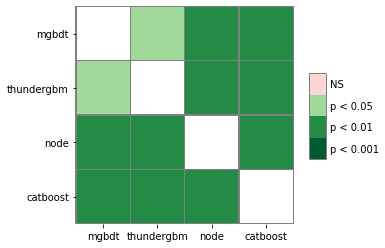

In [78]:
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}

sp.sign_plot(df_nemenyi, **heatmap_args,)

## Plots

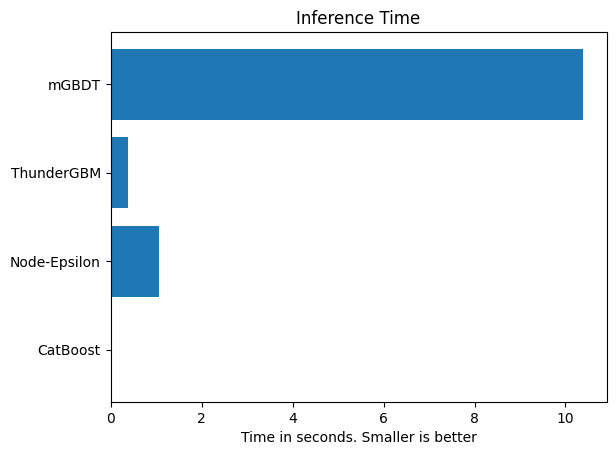

In [252]:
plt.rcdefaults()
fig, ax = plt.subplots()

algorithms = ('mGBDT', 'ThunderGBM', 'Node-Epsilon', 'CatBoost')
y_pos = np.arange(len(algorithms))
performance = np.array([np.mean(mgbdt_time), np.mean(thunder_time),
                        np.mean(node_time),  np.mean(cat_time)])

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(algorithms)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Time in seconds. Smaller is better')
ax.set_title('Inference Time')

plt.show()

In [36]:
max_list = ['mgbdt' if max(a,b,c,d) == a 
            else 'thundergbm' if max(a,b,c,d) == b
            else 'node_epsilon' if max(a,b,c,d) == c 
            else 'catboost' 
            for a, b, c, d in zip(mgbdt_auc, thunder_auc, node_auc, cat_auc)]


In [38]:
counter = Counter(max_list)

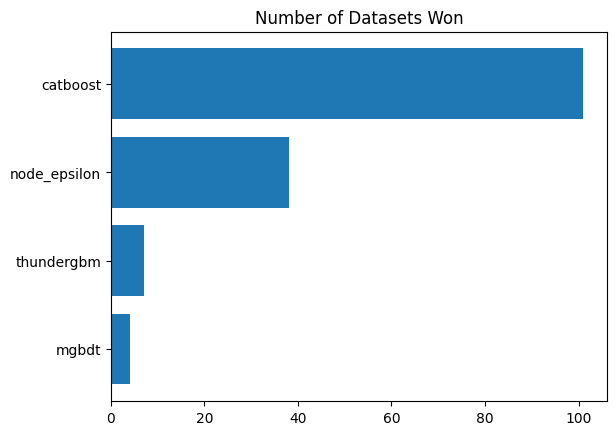

In [42]:

plt.rcdefaults()
fig, ax = plt.subplots()

algorithms = counter.keys()
y_pos = np.arange(len(algorithms))
performance = counter.values()

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(algorithms)
ax.invert_yaxis()  # labels read top-to-bottom
# ax.set_xlabel('Number of datasets won')
ax.set_title('Number of Datasets Won')

plt.show()

# Meta-Learning

In [79]:
df_meta = pd.read_csv('/path/to/meta_features_prep.csv')

In [80]:
df_meta = df_meta.iloc[:,2:]

In [81]:
X = df_meta.iloc[:, :-1].values
y = df_meta.iloc[:, -1].values

In [82]:
logo = LeaveOneGroupOut()

In [83]:
logo.get_n_splits(X, y, groups=np.repeat(range(1,151), 4))

150

In [103]:
groups = np.repeat(range(1,151), 4)

In [249]:
pl.rcParams['figure.figsize'] = [15,25]

mean acc 0.8433333333333334
mean roc_auc 0.8533333333333334


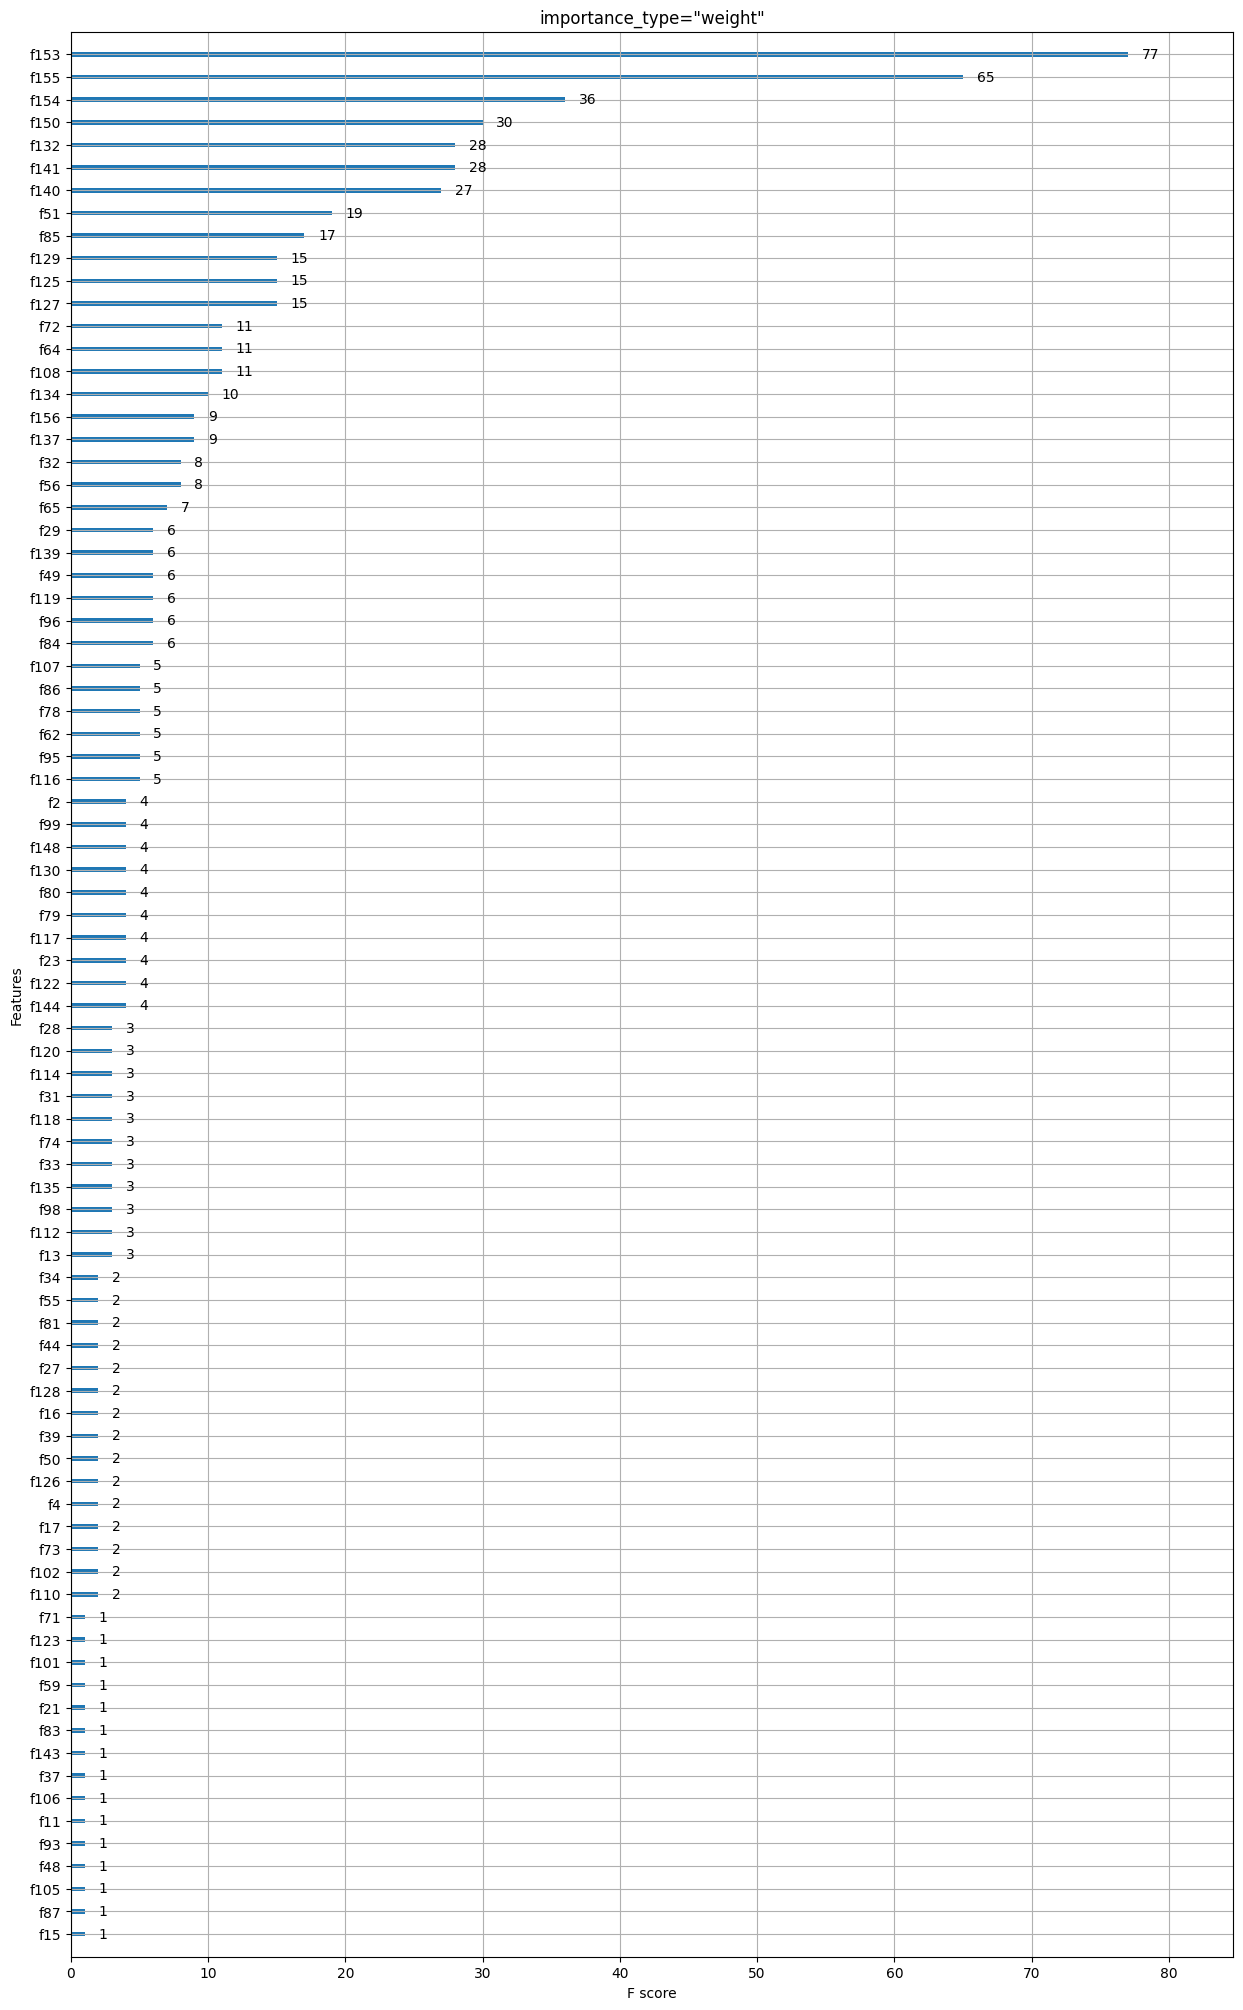

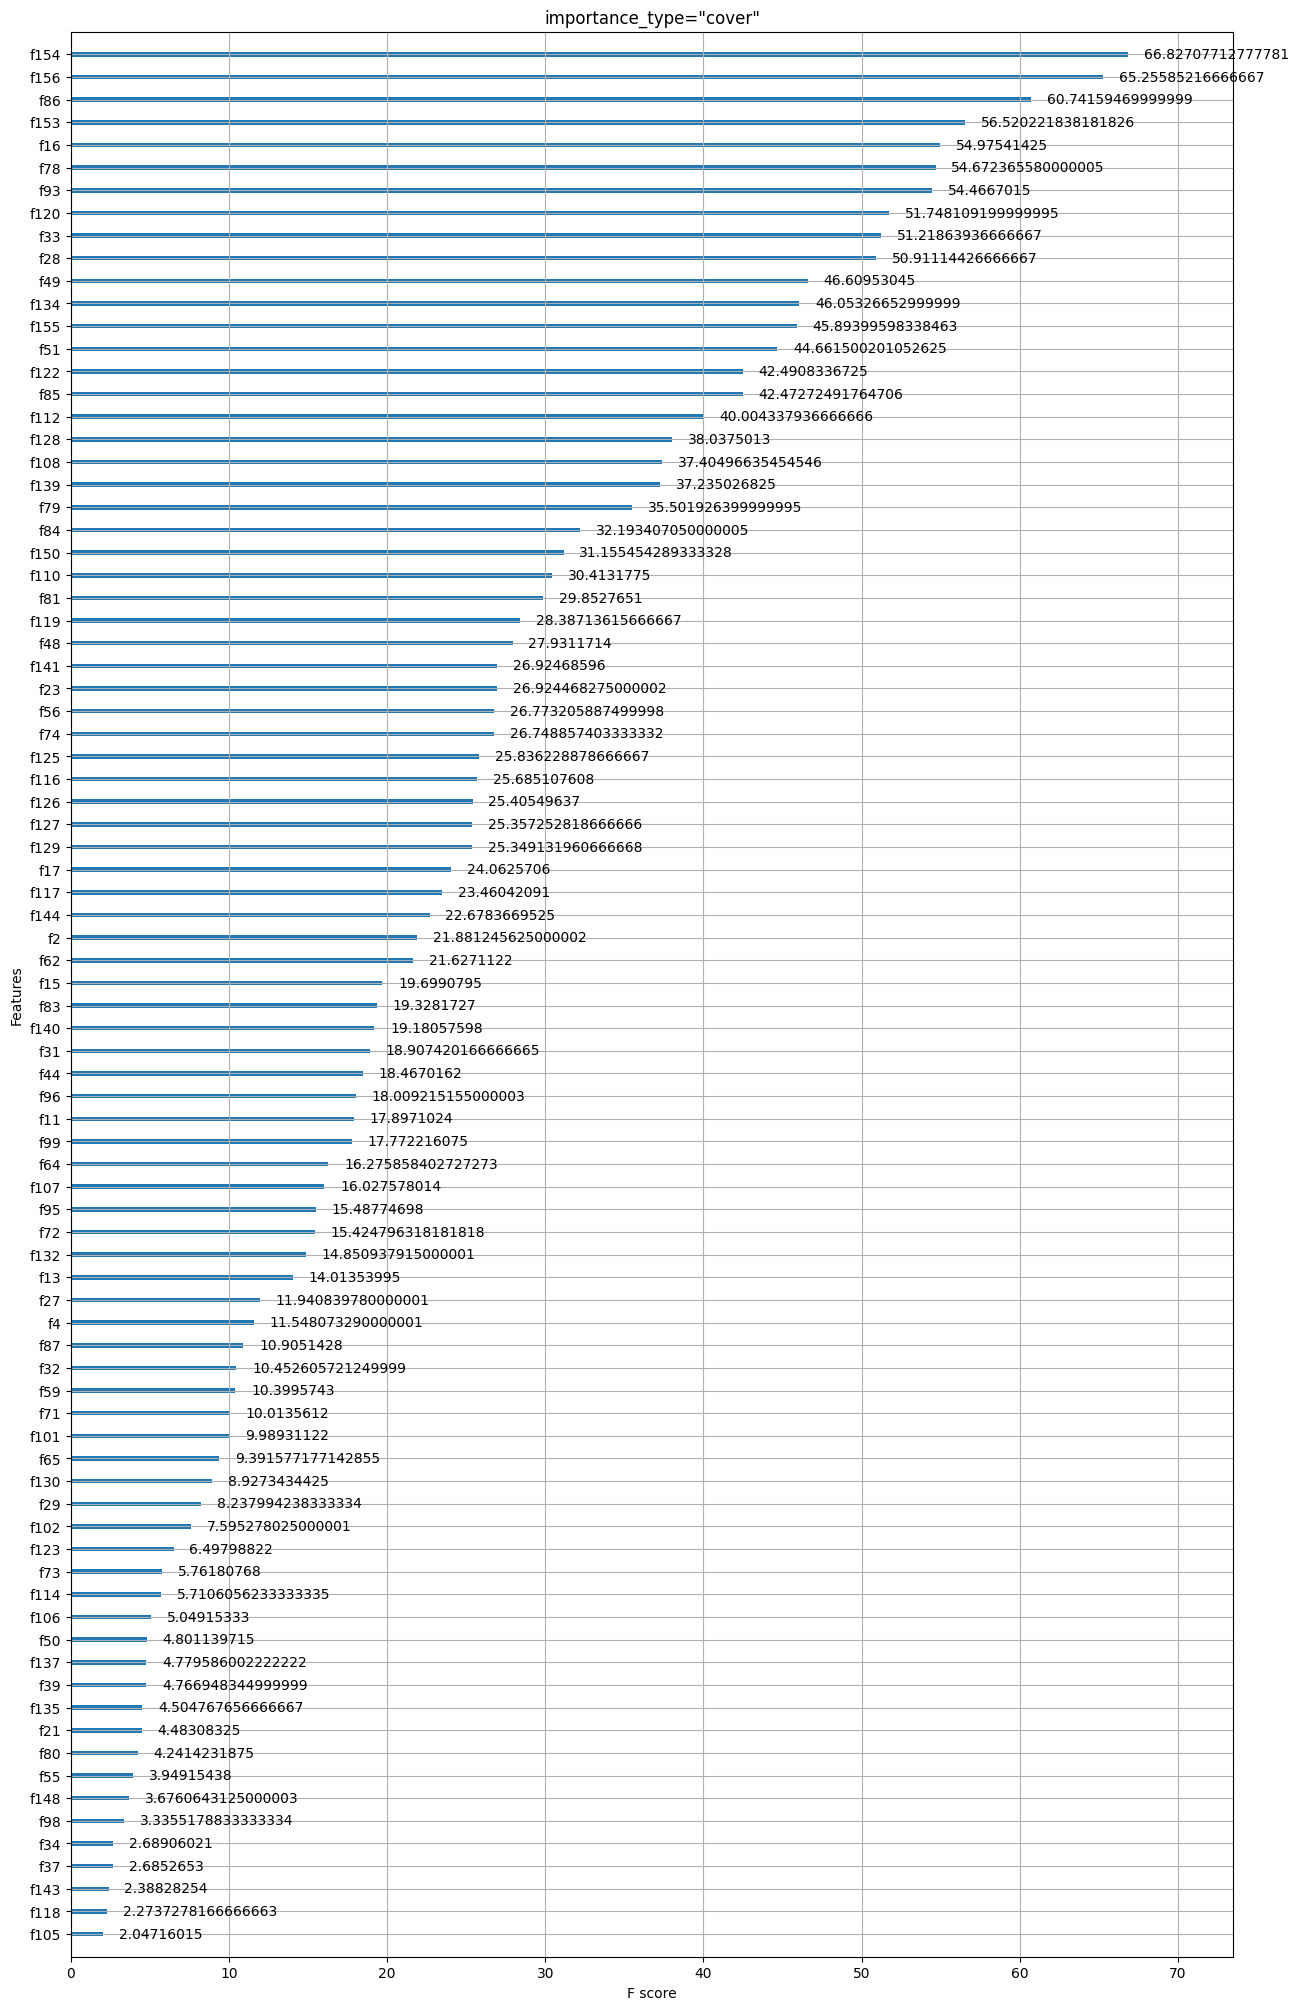

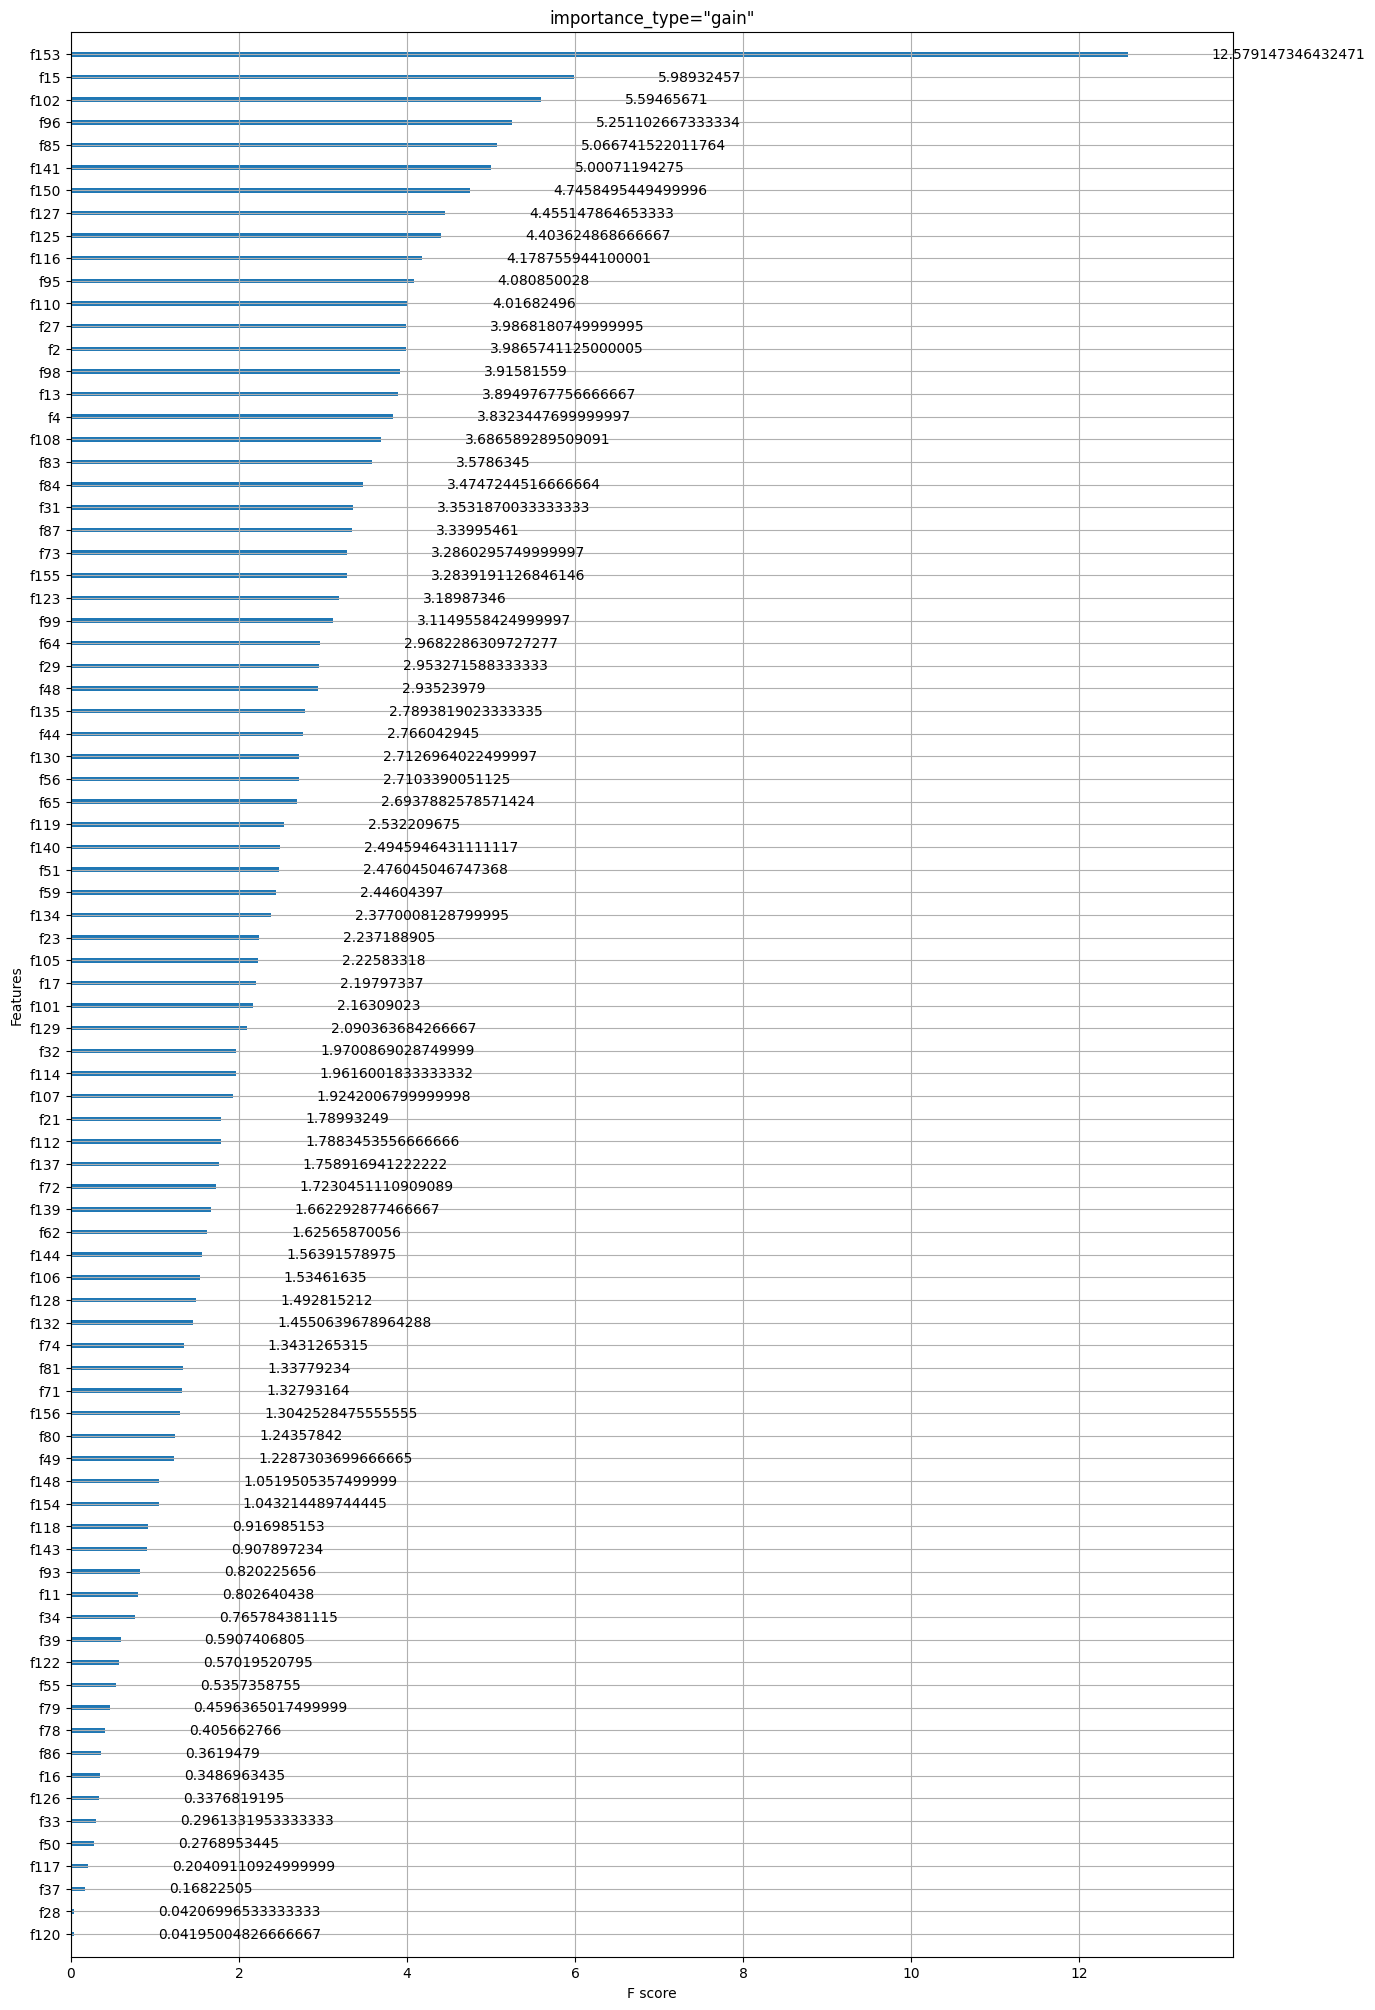

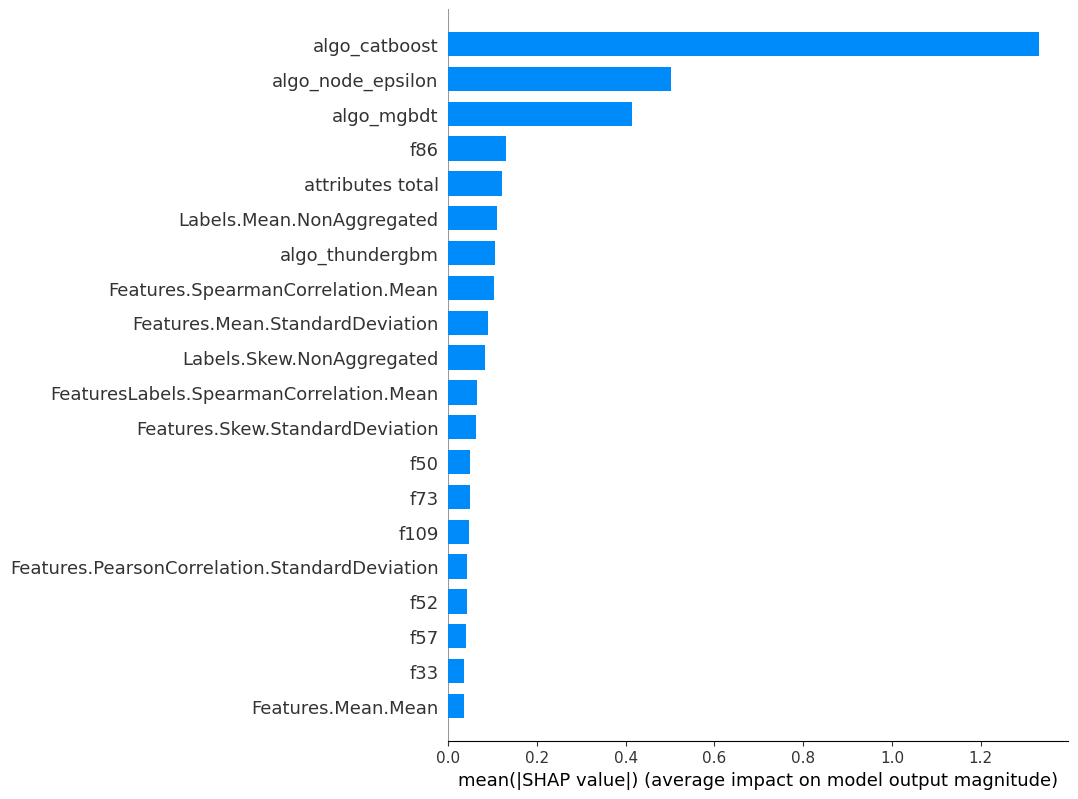

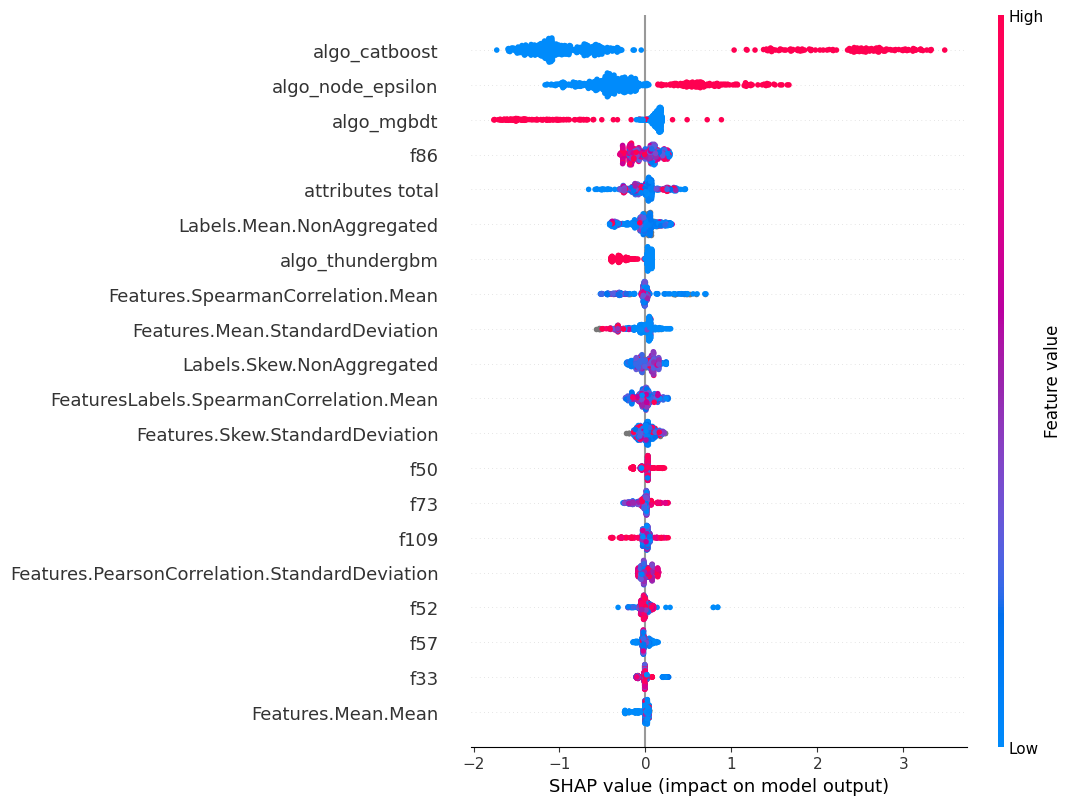

In [250]:
acc_list = []
roc_auc_list = []

for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = XGBClassifier()
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)

    explainer = shap.TreeExplainer(model)

    acc = accuracy_score(y_test, np.argmax(y_pred, axis=1))
    acc_list.append(acc)

    roc_auc = roc_auc_score(y_test, y_pred[:, 1])
    roc_auc_list.append(roc_auc)

print('mean acc',np.nanmean(acc_list))
print('mean roc_auc',np.nanmean(roc_auc_list))

plot_importance(model, importance_type='weight')
pl.title('importance_type="weight"')
pl.show()

plot_importance(model, importance_type="cover")
pl.title('importance_type="cover"')
pl.show()

plot_importance(model, importance_type="gain")
pl.title('importance_type="gain"')
pl.show()

shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, feature_names=df_meta.iloc[:,:-1].columns, plot_type="bar")
shap.summary_plot(shap_values, X, feature_names=df_meta.iloc[:,:-1].columns)


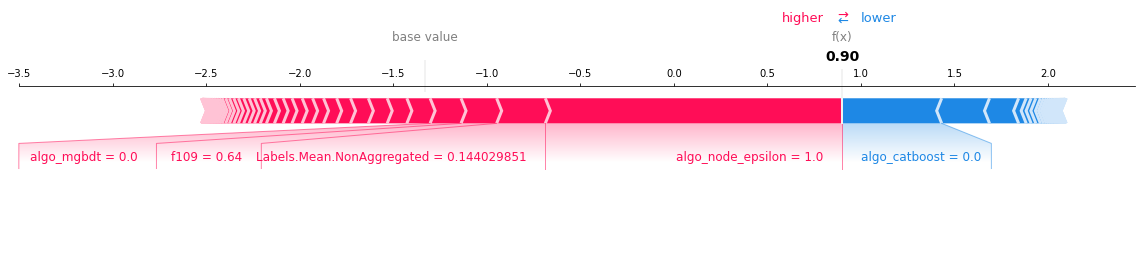

None

In [211]:
shap_display = shap.force_plot(explainer.expected_value, shap_values[62, :], X[62, :], feature_names=df_meta.iloc[:,:-1].columns, matplotlib=True)

display(shap_display)